## Coding BERT with Pytorch
Let’s understand with code how to build BERT with PyTorch. 

We will break the entire program into 4 sections:

1. Preprocessing
2. Building model
3. Loss and Optimization
4. Training

In [25]:
import math
import re
from random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys

In [26]:
torch.set_printoptions(threshold=torch.inf, linewidth=200)
sys.setrecursionlimit(10000)

# Set NumPy print options (used by PyTorch internally for tensor formatting)
np.set_printoptions(threshold=np.inf)

#### 1. Preprocessing

In preprocessing we will structure the data such that the neural network can process it. We start by assigning a raw text for training. 

In [27]:
text = (
        'Hello, how are you? I am Romeo.\n'
        'Hello, Romeo My name is Juliet. Nice to meet you.\n'
        'Nice meet you too. How are you today?\n'
        'Great. My baseball team won the competition.\n'
        'Oh Congratulations, Juliet\n'
        'Thanks you Romeo'
    )

Then we will clean the data by:

- Making the sentences into lower case.

- Creating vocabulary. Vocabulary is a list of unique words in the document. 

In [28]:
sentences = re.sub("[.,!?\\-]", '', text.lower()).split('\n')  # filter '.', ',', '?', '!'

In [29]:
sentences

['hello how are you i am romeo',
 'hello romeo my name is juliet nice to meet you',
 'nice meet you too how are you today',
 'great my baseball team won the competition',
 'oh congratulations juliet',
 'thanks you romeo']

In [30]:
word_list = list(set(" ".join(sentences).split()))

In [31]:
word_list

['great',
 'thanks',
 'won',
 'is',
 'too',
 'competition',
 'the',
 'you',
 'team',
 'are',
 'i',
 'nice',
 'how',
 'congratulations',
 'baseball',
 'oh',
 'today',
 'hello',
 'name',
 'my',
 'meet',
 'am',
 'romeo',
 'juliet',
 'to']

Now, in the following step, it is important to remember that BERT takes special tokens during training. Here is a table explaining the purpose of various tokens:

Token
1. [CLS]

The first token is always classification

2. [SEP]

Separates two sentences

3. [END]

End the sentence.

4. [PAD]

Use to truncate the sentence with equal length.

5. [MASK]

Use to create a mask by replacing the original word.

These tokens should be included in the word dictionary where each token and word in the vocabulary is assigned with an index number. 

In [32]:
word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
for i, w in enumerate(word_list):
   word_dict[w] = i + 4
   number_dict = {i: w for i, w in enumerate(word_dict)}
   vocab_size = len(word_dict)

In [33]:
word_dict

{'[PAD]': 0,
 '[CLS]': 1,
 '[SEP]': 2,
 '[MASK]': 3,
 'great': 4,
 'thanks': 5,
 'won': 6,
 'is': 7,
 'too': 8,
 'competition': 9,
 'the': 10,
 'you': 11,
 'team': 12,
 'are': 13,
 'i': 14,
 'nice': 15,
 'how': 16,
 'congratulations': 17,
 'baseball': 18,
 'oh': 19,
 'today': 20,
 'hello': 21,
 'name': 22,
 'my': 23,
 'meet': 24,
 'am': 25,
 'romeo': 26,
 'juliet': 27,
 'to': 28}

In [34]:
number_dict

{0: '[PAD]',
 1: '[CLS]',
 2: '[SEP]',
 3: '[MASK]',
 4: 'great',
 5: 'thanks',
 6: 'won',
 7: 'is',
 8: 'too',
 9: 'competition',
 10: 'the',
 11: 'you',
 12: 'team',
 13: 'are',
 14: 'i',
 15: 'nice',
 16: 'how',
 17: 'congratulations',
 18: 'baseball',
 19: 'oh',
 20: 'today',
 21: 'hello',
 22: 'name',
 23: 'my',
 24: 'meet',
 25: 'am',
 26: 'romeo',
 27: 'juliet',
 28: 'to'}

In [35]:
token_list = list()
for sentence in sentences:
    arr = [word_dict[s] for s in sentence.split()]
    token_list.append(arr)

In [36]:
token_list

[[21, 16, 13, 11, 14, 25, 26],
 [21, 26, 23, 22, 7, 27, 15, 28, 24, 11],
 [15, 24, 11, 8, 16, 13, 11, 20],
 [4, 23, 18, 12, 6, 10, 9],
 [19, 17, 27],
 [5, 11, 26]]

Once that is taken care of, we need to create a function that formats the input sequences for three types of embeddings: token embedding, segment embedding, and position embedding.

What is token embedding?

For instance, if the sentence is “The cat is walking. The dog is barking”, then the function should create a sequence in the following manner: “[CLS] the cat is walking [SEP] the dog is barking”. 

After that, we convert everything to an index from the word dictionary. So the previous sentence would look something like “[1, 5, 7, 9, 10, 2, 5, 6, 9, 11]”. Keep in mind that 1 and 2 are [CLS] and [SEP] respectively. 

What is segment embedding?

A segment embedding separates two sentences from each other and they are generally defined as 0 and 1. 

What is position embedding?

A position embedding gives position to each embedding in a sequence. 

We will create a function for position embedding later.

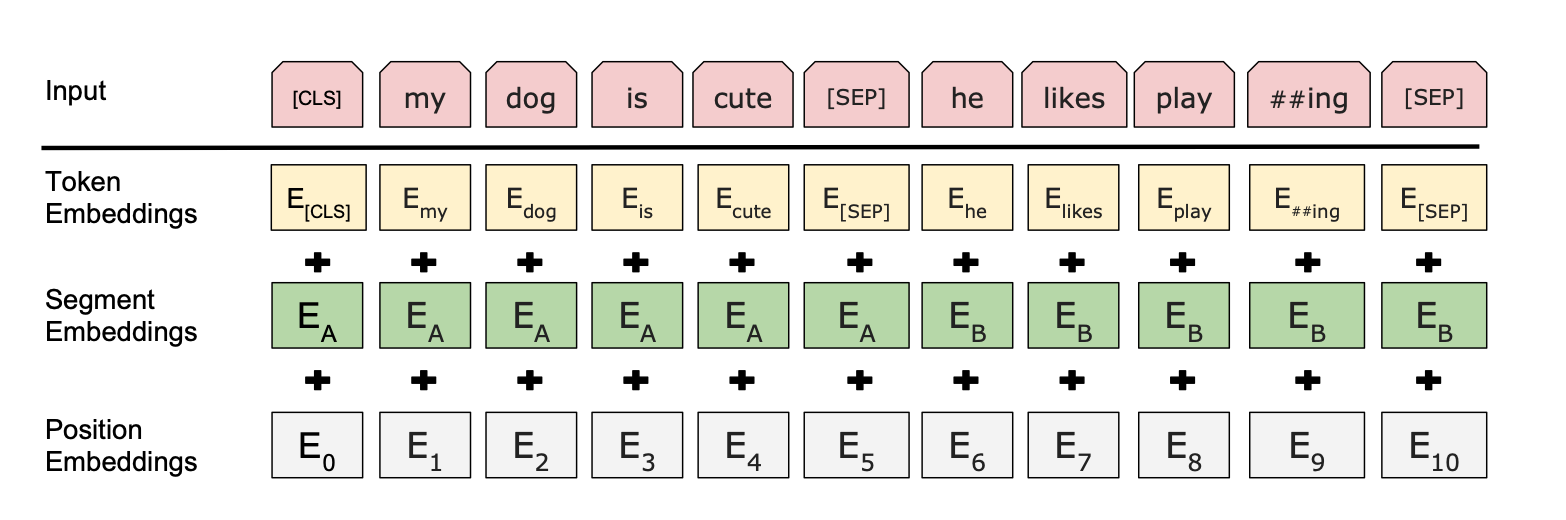

Now the next step will be to create masking. 

As mentioned in the original paper, BERT randomly assigns masks to 15% of the sequence. But keep in mind that you don’t assign masks to the special tokens. For that, we will use conditional statements.

Once we replace 15% of the words with [MASK] tokens, we will add padding. Padding is usually done to make sure that all the sentences are of equal length. For instance, if we take the sentence :

 “The cat is walking. The dog is barking at the tree”

then with padding, it will look like this: 

“[CLS] The cat is walking [PAD] [PAD] [PAD]. [CLS] The dog is barking at the tree.” 

The length of the first sentence is equal to the length of the second sentence.

In [37]:
maxlen = 30 # maximum of length
batch_size = 6
max_pred = 5  # max tokens of prediction
n_layers = 6 # number of Encoder of Encoder Layer
n_heads = 12 # number of heads in Multi-Head Attention
d_model = 768 # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2

In [60]:

def make_batch():
    batch = []
    positive = negative = 0
    while positive != batch_size/2 or negative != batch_size/2:
        tokens_a_index, tokens_b_index= randrange(len(sentences)), randrange(len(sentences))
        tokens_a, tokens_b= token_list[tokens_a_index], token_list[tokens_b_index]
        print("Token Index :",tokens_a_index, tokens_b_index)
        print("Tokens :", tokens_a, tokens_b)
        input_ids = [word_dict['[CLS]']] + tokens_a + [word_dict['[SEP]']] + tokens_b + [word_dict['[SEP]']]

        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        #MASK LM
        n_pred =  min(max_pred, max(1, int(round(len(input_ids) * 0.15)))) # 15 % of tokens in one sentence

        cand_maked_pos = [i for i, token in enumerate(input_ids)
                          if token != word_dict['[CLS]'] and token != word_dict['[SEP]']]
        shuffle(cand_maked_pos)
        masked_tokens, masked_pos = [], []
        for pos in cand_maked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            if random() < 0.8:  # 80%
                input_ids[pos] = word_dict['[MASK]'] # make mask
            elif random() < 0.5:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                input_ids[pos] = word_dict[number_dict[index]] # replace

        # Zero Paddings
        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

    #     # Zero Padding (100% - 15%) tokens
        if max_pred > n_pred:
            n_pad = max_pred - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        if tokens_a_index + 1 == tokens_b_index and positive < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
            negative += 1
    return batch


In [63]:
token_list

[[21, 16, 13, 11, 14, 25, 26],
 [21, 26, 23, 22, 7, 27, 15, 28, 24, 11],
 [15, 24, 11, 8, 16, 13, 11, 20],
 [4, 23, 18, 12, 6, 10, 9],
 [19, 17, 27],
 [5, 11, 26]]

In [62]:
batch = make_batch()

Token Index : 2 3
Tokens : [15, 24, 11, 8, 16, 13, 11, 20] [4, 23, 18, 12, 6, 10, 9]
Token Index : 5 2
Tokens : [5, 11, 26] [15, 24, 11, 8, 16, 13, 11, 20]
Token Index : 2 2
Tokens : [15, 24, 11, 8, 16, 13, 11, 20] [15, 24, 11, 8, 16, 13, 11, 20]
Token Index : 1 4
Tokens : [21, 26, 23, 22, 7, 27, 15, 28, 24, 11] [19, 17, 27]
Token Index : 2 5
Tokens : [15, 24, 11, 8, 16, 13, 11, 20] [5, 11, 26]
Token Index : 3 3
Tokens : [4, 23, 18, 12, 6, 10, 9] [4, 23, 18, 12, 6, 10, 9]
Token Index : 1 0
Tokens : [21, 26, 23, 22, 7, 27, 15, 28, 24, 11] [21, 16, 13, 11, 14, 25, 26]
Token Index : 0 3
Tokens : [21, 16, 13, 11, 14, 25, 26] [4, 23, 18, 12, 6, 10, 9]
Token Index : 2 0
Tokens : [15, 24, 11, 8, 16, 13, 11, 20] [21, 16, 13, 11, 14, 25, 26]
Token Index : 3 5
Tokens : [4, 23, 18, 12, 6, 10, 9] [5, 11, 26]
Token Index : 2 5
Tokens : [15, 24, 11, 8, 16, 13, 11, 20] [5, 11, 26]
Token Index : 4 0
Tokens : [19, 17, 27] [21, 16, 13, 11, 14, 25, 26]
Token Index : 3 1
Tokens : [4, 23, 18, 12, 6, 10, 9]

In [61]:
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

Since we are dealing with next-word prediction, we have to create a label that predicts whether the sentence has a consecutive sentence or not, i.e. IsNext or NotNext. So we assign True for every sentence that precedes the next sentence and we use a conditional statement to do that. 

For instance, two sentences in a document usually follow each other if they are in context. So assuming the first sentence is A then the next sentence should be A+1. Intuitively we write the code such that if the first sentence positions i.e. tokens_a_index + 1 == tokens_b_index,  i.e. second sentence in the same context, then we can set the label for this input as True. 

If the above condition is not met i.e. if tokens_a_index + 1 != tokens_b_index then we set the label for this input as False. 

## Building model
BERT is a complex model and if it is perceived slowly you lose track of the logic. So it’ll only make sense to explain its component by component and their function.

BERT has the following components:

- Embedding layers
- Attention Mask
- Encoder layer
- Multi-head attention
- Scaled dot product attention
- Position-wise feed-forward network
- BERT (assembling all the components)

1. Embedding layer
The embedding is the first layer in BERT that takes the input and creates a lookup table. The parameters of the embedding layers are learnable, which means when the learning process is over the embeddings will cluster similar words together. 

The embedding layer also preserves different relationships between words such as: semantic, syntactic, linear, and since BERT is bidirectional it will also preserve contextual relationships as well. 

In the case of BERT, it creates three embeddings for 

- Token, 
- Segments and
- Position. 
 

Creating attention mask
BERT needs attention masks. And these should be in a proper format. The following code will help you create masks. 

It will convert the [PAD] to 1 and elsewhere 0. 

In the forward function, we sum up all the embeddings and normalize them

In [40]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(maxlen, d_model)  # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long)
        print("Position indices:", pos)  # Debug print
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        # print("Expanded position indices:", pos)  # Debug print
        temp = self.tok_embed(x)
        # print("Token embedding: ",temp)
        temp2 = self.pos_embed(pos)
        # print("Position embedd : ",temp2)
        temp3 = self.seg_embed(seg)
        # print("Segment embedd: ",temp3)
        embedding = temp + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

### Creating attention mask

BERT needs attention masks. And these should be in a proper format. The following code will help you create masks. 

It will convert the [PAD] to 1 and elsewhere 0.

In [41]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

In [19]:
# print(get_attn_pad_mask(input_ids, input_ids)[0][0], input_ids[0])

### Encoder
The encoder has two main components: 

- Multi-head Attention
- Position-wise feed-forward network. 

The work of the encoder is to find representations and patterns from the input and attention mask. 

In [17]:
class EncoderLayer(nn.Module):
   def __init__(self):
       super(EncoderLayer, self).__init__()
       self.enc_self_attn = MultiHeadAttention()
       self.pos_ffn = PoswiseFeedForwardNet()

   def forward(self, enc_inputs, enc_self_attn_mask):
       enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
       enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
       return enc_outputs, attn

### Multi-head attention

This is the first of the main components of the encoder. 

The attention model takes three inputs: Query, Key, and Value. 

I highly recommend you to read The Illustrated Transformer by Jay Alammar that explains Attention models in depth. 

Multihead attention takes four inputs: Query, Key, Value, and Attention mask. The embeddings are fed as input to the Query, Key, and Value argument, and the attention mask is fed as input to the attention mask argument. 
These three inputs and the attention mask are operated with a dot product operation that yields two outputs: context vectors and attention. The context vector is then passed through a linear layer and finally that yields the output.

In [42]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(n_heads * d_v, d_model)(context)
        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]

Now, let’s explore this Scaled Dot Product attention:

- The scaled dot product attention class takes four arguments: Query, Key, Value, and Attention mask. Essentially, the first three arguments are fed with the word embeddings and the attention mask argument is fed with attention mask embeddings.

- Then it does a matrix multiplication between query and key to get scores. 

Following that we use scores.masked_fill_(attn_mask, -1e9) . This attribute fills the element of scores with -1e9 where the attention masks are True while the rest of the elements get an attention score which is then passed through a softmax function that gives a score between 0 and 1. Finally, we perform a matrix multiplication between attention and values which gives us the context vectors. 

In [43]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn 

In [44]:
batch = make_batch()

In [45]:
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

In [46]:
input_ids.shape

torch.Size([6, 30])

In [59]:
token_list

[[21, 16, 13, 11, 14, 25, 26],
 [21, 26, 23, 22, 7, 27, 15, 28, 24, 11],
 [15, 24, 11, 8, 16, 13, 11, 20],
 [4, 23, 18, 12, 6, 10, 9],
 [19, 17, 27],
 [5, 11, 26]]

In [47]:
input_ids

tensor([[ 1, 21, 16, 13,  3, 14, 25,  3,  2, 21, 26, 23, 22,  7,  3, 15, 28, 24, 11,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 19, 17,  3,  2,  5, 11, 26,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  4, 23, 18, 12,  6, 10,  3,  2,  3, 17, 27,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 21, 26, 23, 22,  7, 27, 15, 28, 24,  3,  2, 21,  3, 13, 11, 14, 25,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  3, 11, 26,  2, 19, 17, 27,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 21,  3, 13, 11, 14, 25, 26,  2, 19, 17,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [48]:
pad = get_attn_pad_mask(input_ids, input_ids)

In [49]:
emb = Embedding()

In [50]:
emb

Embedding(
  (tok_embed): Embedding(29, 768)
  (pos_embed): Embedding(30, 768)
  (seg_embed): Embedding(2, 768)
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [81]:
segment_ids

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [82]:
embeds = emb(input_ids, segment_ids)

Position indices: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])


In [84]:
attenM = get_attn_pad_mask(input_ids, input_ids)

In [88]:
SDPA= ScaledDotProductAttention()(embeds, embeds, embeds, attenM)

In [89]:
S, C, A = SDPA

In [93]:
print('Scores: ', S[0][0],'nnAttention Scores after softmax: ', A[0][0])

Scores:  tensor([ 9.6000e+01,  3.1663e+01,  3.6791e+01,  3.6210e+01,  3.1516e+01,  3.0959e+01,  3.2914e+01,  3.5464e+01,  3.4892e+01,  2.9189e+00, -1.9444e+00, -6.1601e+00, -1.0167e+00, -3.0068e+00,
        -7.0433e+00,  4.5209e+00,  3.6036e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09], grad_fn=<SelectBackward0>) nnAttention Scores after softmax:  tensor([1.0000e+00, 1.1454e-28, 1.9322e-26, 1.0809e-26, 9.8858e-29, 5.6662e-29, 4.0006e-28, 5.1268e-27, 2.8916e-27, 3.7632e-41, 2.9007e-43, 4.2039e-45, 7.3568e-43, 1.0089e-43, 1.4013e-45, 1.8675e-40,
        7.4626e-41, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<SelectBackward0>)


In [94]:
# emb = Embedding()
# embeds = emb(input_ids, segment_ids)

# attenM = get_attn_pad_mask(input_ids, input_ids)

# SDPA= ScaledDotProductAttention()(embeds, embeds, embeds, attenM)

# S, C, A = SDPA

# print('Masks',masks[0][0])
# print()
# print('Scores: ', S[0][0],'nnAttention Scores after softmax: ', A[0][0])

In [51]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

### Position-Wise Feed Forward Network

The output from the multihead goes into the feed-forward network and that concludes the encoder part.

Let’s take a breath and revise what we’ve learned so far:

The input goes into the embedding and as well attention function. Both of which are fed into the encoder which has a multi-head function and a feed-forward network. 

The multi-head function itself has a function that operates the embeddings and attention mask using a dot product operation. 
BERT building model
Source: Author
Assembling all the components
Let’s continue from where we left, i.e. the output from the encoder.

The encoder yields two outputs: 

One which comes from the feed-forward layer and 
the Attention mask. 

It’s key to remember that BERT does not explicitly use a decoder. Instead, it uses the output and the attention mask to get the desired result. 

Although the decoder section in the transformers is replaced with a shallow network which can be used for classification as shown in the code below.
Also, BERT outputs two results: one for the classifier and the other for masked.

In [52]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(gelu(self.fc1(x)))

In [53]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

In [54]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.embedding = Embedding()
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ1 = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.activ2 = gelu
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        # it will be decided by first token(CLS)
        h_pooled = self.activ1(self.fc(output[:, 0])) # [batch_size, d_model]
        print("H-Pooled :",h_pooled)
        logits_clsf = self.classifier(h_pooled) # [batch_size, 2]
        print("Logits_clsf: ",logits_clsf)

        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        # get masked position from final output of transformer.
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked = self.norm(self.activ2(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]
        
        return logits_lm, logits_clsf

In [103]:
# model = BERT()

# # Get all trainable parameters
# trainable_params = [p for p in model.parameters() if p.requires_grad]

# # Print the total number of trainable parameters
# total_params = sum(p.numel() for p in trainable_params)
# print(f"Total trainable parameters: {total_params}")

# # Optionally, print details of each parameter
# for i, param in enumerate(trainable_params):
#     print(f"Parameter {i+1}: {param.size()}, Total elements: {param.numel()}")

In [102]:
model = BERT()  # Your model instance

# Print names and shapes of all trainable parameters
for name, param in model.named_parameters():
    if param.requires_grad:  # Check if the parameter is trainable
        print(f"Name: {name}, Shape: {param.size()}, Total Elements: {param.numel()}")

Name: decoder_bias, Shape: torch.Size([29]), Total Elements: 29
Name: embedding.tok_embed.weight, Shape: torch.Size([29, 768]), Total Elements: 22272
Name: embedding.pos_embed.weight, Shape: torch.Size([30, 768]), Total Elements: 23040
Name: embedding.seg_embed.weight, Shape: torch.Size([2, 768]), Total Elements: 1536
Name: embedding.norm.weight, Shape: torch.Size([768]), Total Elements: 768
Name: embedding.norm.bias, Shape: torch.Size([768]), Total Elements: 768
Name: layers.0.enc_self_attn.W_Q.weight, Shape: torch.Size([768, 768]), Total Elements: 589824
Name: layers.0.enc_self_attn.W_Q.bias, Shape: torch.Size([768]), Total Elements: 768
Name: layers.0.enc_self_attn.W_K.weight, Shape: torch.Size([768, 768]), Total Elements: 589824
Name: layers.0.enc_self_attn.W_K.bias, Shape: torch.Size([768]), Total Elements: 768
Name: layers.0.enc_self_attn.W_V.weight, Shape: torch.Size([768, 768]), Total Elements: 589824
Name: layers.0.enc_self_attn.W_V.bias, Shape: torch.Size([768]), Total Elemen

In [55]:
model = BERT()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch = make_batch()
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

for epoch in range(10):
    optimizer.zero_grad()
    logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos)
    loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
    loss_lm = (loss_lm.float()).mean()
    loss_clsf = criterion(logits_clsf, isNext) # for sentence classification
    loss = loss_lm + loss_clsf
    if (epoch + 1) % 10 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

Position indices: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
H-Pooled : tensor([[-1.5206e-01,  1.0969e-02,  1.0858e-01,  1.4298e-01,  1.8209e-01, -3.2951e-02, -6.4575e-03, -1.1189e-01, -1.3522e-01, -1.5860e-02, -4.2280e-03, -1.6535e-02,  1.0531e-01, -9.5692e-02,
          1.8006e-01, -6.2223e-02, -6.8004e-03, -1.1656e-02, -2.5343e-02, -1.6989e-01,  4.6926e-03,  1.5187e-03,  1.1395e-01,  3.8308e-02, -3.3690e-02,  6.8752e-03, -1.1643e-01,  3.1442e-02,
         -1.6420e-01,  2.6564e-02, -1.0997e-02, -1.0908e-01,  2.4195e-01,  5.2961e-02, -1.6688e-02, -1.1006e-01,  9.5685e-02, -3.2151e-02, -2.5424e-02,  7.6922e-03, -2.4721e-01, -4.1559e-02,
          1.3046e-01,  2.3670e-01, -2.7844e-02, -3.0737e-02,  1.7892e-02,  1.1747e-01,  4.0354e-02, -1.2570e-01,  1.7217e-01, -1.4814e-01,  1.5414e-01, -7.5408e-02, -2.6348e-02,  2.7081e-02,
         -6.8819e-02, -1.1251e-01,  3.1443e-02, -1.3385e-01, -7.2465e-02, -2.1

In [57]:
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(batch[0]))

In [64]:
token_list

[[21, 16, 13, 11, 14, 25, 26],
 [21, 26, 23, 22, 7, 27, 15, 28, 24, 11],
 [15, 24, 11, 8, 16, 13, 11, 20],
 [4, 23, 18, 12, 6, 10, 9],
 [19, 17, 27],
 [5, 11, 26]]

In [66]:
word_dict

{'[PAD]': 0,
 '[CLS]': 1,
 '[SEP]': 2,
 '[MASK]': 3,
 'great': 4,
 'thanks': 5,
 'won': 6,
 'is': 7,
 'too': 8,
 'competition': 9,
 'the': 10,
 'you': 11,
 'team': 12,
 'are': 13,
 'i': 14,
 'nice': 15,
 'how': 16,
 'congratulations': 17,
 'baseball': 18,
 'oh': 19,
 'today': 20,
 'hello': 21,
 'name': 22,
 'my': 23,
 'meet': 24,
 'am': 25,
 'romeo': 26,
 'juliet': 27,
 'to': 28}

In [65]:
input_ids[0]

tensor([ 1, 15, 24, 11,  8,  5, 13, 11, 20,  2, 21,  1, 13, 11, 14, 25, 26,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [56]:
# Predict mask tokens ans isNext
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(batch[0]))
print(text)
print([number_dict[w.item()] for w in input_ids[0] if number_dict[w.item()] != '[PAD]'])

logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos)
logits_lm = logits_lm.data.max(2)[1][0].data.numpy()
print('masked tokens list : ',[pos.item() for pos in masked_tokens[0] if pos.item() != 0])
print('predict masked tokens list : ',[pos for pos in logits_lm if pos != 0])

logits_clsf = logits_clsf.data.max(1)[1].data.numpy()[0]
print('isNext : ', True if isNext else False)
print('predict isNext : ',True if logits_clsf else False)

Hello, how are you? I am Romeo.
Hello, Romeo My name is Juliet. Nice to meet you.
Nice meet you too. How are you today?
Great. My baseball team won the competition.
Oh Congratulations, Juliet
Thanks you Romeo
['[CLS]', 'nice', 'meet', 'you', 'too', 'thanks', 'are', 'you', 'today', '[SEP]', 'hello', '[CLS]', 'are', 'you', 'i', 'am', 'romeo', '[SEP]']
Position indices: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
H-Pooled : tensor([[ 0.8827, -0.9999, -0.9841,  0.9991,  1.0000,  0.9998, -1.0000, -0.9990, -1.0000, -1.0000,  0.9869,  0.9990, -0.9986,  1.0000, -0.9987, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000,
          0.9987, -1.0000, -1.0000, -0.9999,  0.9987, -0.9999,  0.9980, -1.0000,  1.0000,  1.0000,  0.9985, -1.0000,  0.7630,  1.0000, -0.9999,  0.8712,  1.0000,  1.0000, -1.0000, -0.9345, -1.0000,
         -0.9888, -0.9726,  0.9858,  0.9967, -0.9990,  0.9652, -0.9735, -0.9998, -0.9581, -1.0